# SUMMA Turbulence Scheme Conversion
### Testing of offline turbulence against Snoqualmie observations

In [19]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xray
import kray
import scipy.io as sio

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
sns.set_context('talk')
sns.set_style('whitegrid')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph
import matplotlib.gridspec as gridspec

import turbpy

In [2]:
#### Directory Lists
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dirProj = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/'           # Project directory
dirPrint = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'  # Directory for printing figures
dirData = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ'    # Processed data directory

# Apply to Snoqualmie Observations

## Read Snoqualmie Obs

In [3]:
## Read the formatted supporting snoqualmie obs
os.chdir(dirData)
support = xray.open_dataset('SnoqualmieObs.SupportData.wy2013_wy2015.nc')

In [4]:
## Met variables
mHeight = 6.
scalarGroundSnowFraction  = 1.
soilRelHumidity = 1.

# Turbulence parameters
z0Ground = .005

## Misc. variables
ixStability = ('standard','louisInversePower','mahrtExponential','moninObukhov')

## Discriminate for only wind > 2ms-1

In [5]:
## Select only turbulence data that meets the assumptions for eddy-covariance
ind = np.nonzero ( (support.SP == 1).values &\
                  (support.WIND > 2).values & \
                  (~(np.isnan(support.SensFlux)).values |\
                  ~(np.isnan(support.LatFlux)).values)
                  )
snoqTurbObs = xray.Dataset({'sensible' : (['time'], support.SensFlux[ind].values),
                'latent' : (['time'], support.LatFlux[ind].values)},
                coords={'time': support.time[ind]})

In [6]:
sensible = xray.Dataset()
sensible.coords['time'] = support.time[ind]
latent = xray.Dataset()
latent.coords['time'] = support.time[ind]

for stab in ixStability:
    senHeatGround = np.ones(support.time[ind].size)*np.nan       # sensible heat flux from ground surface (W m-2)
    latHeatGround = np.ones(support.time[ind].size)*np.nan       # latent heat flux from ground surface (W m-2)
    
    # Loop over each time step with snow
    for n,d in enumerate(support.time[ind]):
        # Met data at Snoqualmie on the given date
        ds = support.sel(time=d)
        snowDepth = ds.Snowdepth  # (m)
        airVaporPress = ds.Vap_press_6  * 1000  # (kPa) -> (Pa)
        airTemp = ds.T6+273.15  # (C) -> (K)
        sfcTemp = ds.Tsrf+273.15  # (C) -> (K)
        sfcVaporPress, _ = turbpy.conversionTools.satVapPress(sfcTemp)
        windspd = ds.WIND  # (m/s)
        
        if np.any(np.isnan([snowDepth, airTemp, sfcTemp, airVaporPress, sfcVaporPress, windspd])):
            continue
        else:
            # Offline turbulence
            (_, _, senHeatGround[n], latHeatGround[n], _, _, _, _) = turbpy.turbFluxes(
                airTemp, 101000, airVaporPress, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
                groundSnowFraction=1, ixStability=stab, z0Ground=.005,
                )
    
    sensible[stab] = (('time'),senHeatGround)
    latent[stab] = (('time'),latHeatGround)

In [7]:
########
# Save sensible/latent offline
sensible.to_netcdf('TF.SNQ_wind2msSP.OfflineTurb.sensible.nc')
latent.to_netcdf('TF.SNQ_wind2msSP.OfflineTurb.latent.nc')

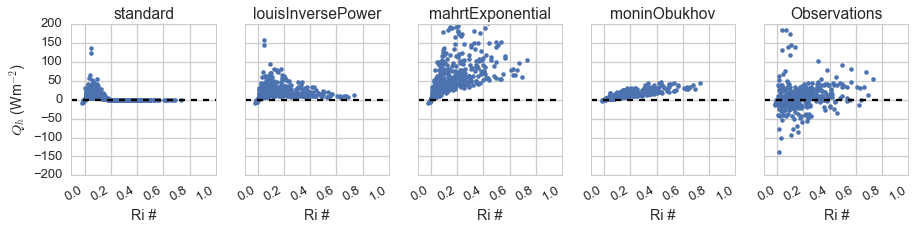

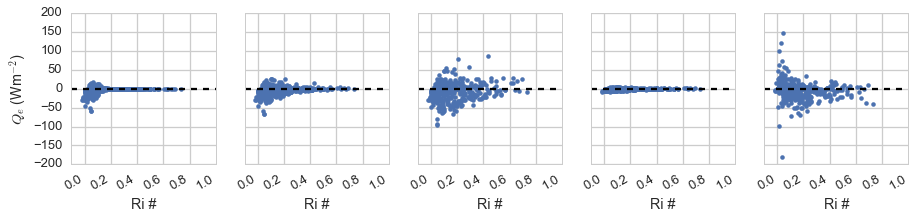

In [20]:
########
# Sensible
os.chdir(dirPrint)
fig,axes = plt.subplots(1,5,sharey=True,figsize=(15,3))
Qmax = 200
Qmin = -200
RiMax = 1.
RiMin = -0.1

Ri = turbpy.bulkRichardson(support.T6[ind]+273.15, support.Tsrf[ind]+273.15, support.WIND[ind], 
                           mHeight-support.Snowdepth[ind], False)

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(Ri[0], sensible[stab],'.',label=stab)
    ax.plot([RiMin,RiMax],[0,0],'k--')
    ax.set_xlim(RiMin,RiMax)
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlabel('Ri #')
    ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('$Q_h$ (Wm$^{-2}$)')

ax = axes[-1]
ax.plot(Ri[0], \
        support.SensFlux[ind],\
        '.',label='Observations')
ax.plot([RiMin,RiMax],[0,0],'k--')
ax.set_ylim(Qmin,Qmax)
ax.set_xlim(RiMin,RiMax)
ax.set_xlabel('Ri #')
ax.set_title('Observations')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Sensible_Ri.pdf')

########
# Latent
os.chdir(dirPrint)
fig,axes = plt.subplots(1,5,sharey=True,figsize=(15,3))

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(Ri[0], latent[stab],'.',label=stab)
    ax.plot([RiMin,RiMax],[0,0],'k--')
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlim(RiMin,RiMax)
    ax.set_xlabel('Ri #')
#     ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('$Q_e$ (Wm$^{-2}$)')

ax = axes[-1]
ax.plot(Ri[0], \
        support.LatFlux[ind],\
        '.',label='Observations')
ax.plot([RiMin,RiMax],[0,0],'k--')
ax.set_ylim(Qmin,Qmax)
ax.set_xlim(RiMin,RiMax)
ax.set_xlabel('Ri #')
# ax.set_title('Observations')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Latent_Ri.pdf')


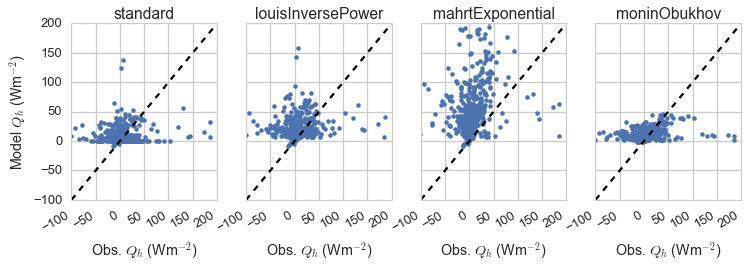

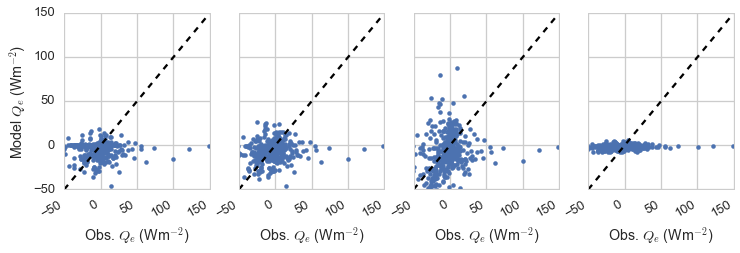

In [23]:
########
# Model Sensible vs Obs Sensible 
os.chdir(dirPrint)
fig,axes = plt.subplots(1,4,sharey=True,figsize=(12,3.5))
Qmax = 200
Qmin = -100

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(support.SensFlux[ind], sensible[stab],'.',label=stab)
    ax.plot([Qmin,Qmax],[Qmin,Qmax],'--k')
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlim(Qmin,Qmax)
    ax.set_xlabel('Obs. $Q_h$ (Wm$^{-2}$)')
    ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('Model $Q_h$ (Wm$^{-2}$)')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Sensible.pdf')

########
# Model Latent vs Obs Latent 
os.chdir(dirPrint)
fig,axes = plt.subplots(1,4,sharey=True,figsize=(12,3.5))
Qmax = 150
Qmin = -50

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(support.LatFlux[ind], latent[stab],'.',label=stab)
    ax.plot([Qmin,Qmax],[Qmin,Qmax],'--k')
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlim(Qmin,Qmax)
    ax.set_xlabel('Obs. $Q_e$ (Wm$^{-2}$)')
#     ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('Model $Q_e$ (Wm$^{-2}$)')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Latent.pdf')


## Use all turbulence data when snow is present

In [ ]:
## Select only turbulence data that meets the assumptions for eddy-covariance
ind = np.nonzero ( (support.SP == 1).values &\
                  (~(np.isnan(support.SensFlux)).values |\
                  ~(np.isnan(support.LatFlux)).values)
                  )
snoqTurbObs = xray.Dataset({'sensible' : (['time'], support.SensFlux[ind].values),
                'latent' : (['time'], support.LatFlux[ind].values)},
                coords={'time': support.time[ind]})

In [13]:
sensible = xray.Dataset()
sensible.coords['time'] = support.time[ind]
latent = xray.Dataset()
latent.coords['time'] = support.time[ind]

for stab in ixStability:
    senHeatGround = np.ones(support.time[ind].size)*np.nan       # sensible heat flux from ground surface (W m-2)
    latHeatGround = np.ones(support.time[ind].size)*np.nan       # latent heat flux from ground surface (W m-2)
    
    # Loop over each time step with snow
    for n,d in enumerate(support.time[ind]):        
        # Met data at Snoqualmie on the given date
        ds = support.sel(time=d)
        snowDepth = ds.Snowdepth  # (m)
        airVaporPress = ds.Vap_press_6  * 1000  # (kPa) -> (Pa)
        airTemp = ds.T6+273.15  # (C) -> (K)
        sfcTemp = ds.Tsrf+273.15  # (C) -> (K)
        sfcVaporPress, _ = turbpy.conversionTools.satVapPress(sfcTemp)
        windspd = ds.WIND  # (m/s)
        
        if np.any(np.isnan([snowDepth, airTemp, sfcTemp, airVaporPress, sfcVaporPress, windspd])):
            continue
        else:
            # Offline turbulence
            (_, _, senHeatGround[n], latHeatGround[n], _, _, _, _) = turbpy.turbFluxes(
                airTemp, 101000, airVaporPress, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
                groundSnowFraction=1, ixStability=stab, z0Ground=.005,
                )

    sensible[stab] = (('time'),senHeatGround)
    latent[stab] = (('time'),latHeatGround)

In [15]:
########
# Save sensible/latent offline
sensible.to_netcdf('TF.SNQ_SP.OfflineTurb.sensible.nc')
latent.to_netcdf('TF.SNQ_SP.OfflineTurb.latent.nc')

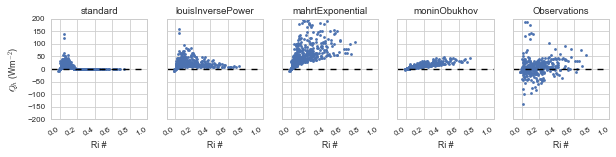

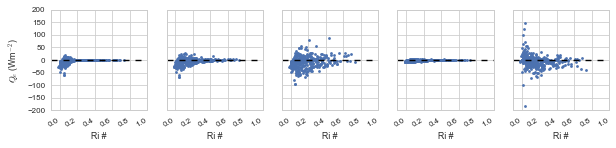

In [16]:
########
# Sensible
os.chdir(dirPrint)
fig,axes = plt.subplots(1,5,sharey=True,figsize=(10,2))
Qmax = 200
Qmin = -200
RiMax = 1.
RiMin = -0.1

Ri = turbpy.bulkRichardson(support.T6[ind]+273.15, support.Tsrf[ind]+273.15, support.WIND[ind], 
                           mHeight-support.Snowdepth[ind], False)

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(Ri[0], sensible[stab],'.',label=stab)
    ax.plot([RiMin,RiMax],[0,0],'k--')
    ax.set_xlim(RiMin,RiMax)
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlabel('Ri #')
    ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('$Q_h$ (Wm$^{-2}$)')

ax = axes[-1]
ax.plot(Ri[0], \
        support.SensFlux[ind],\
        '.',label='Observations')
ax.plot([RiMin,RiMax],[0,0],'k--')
ax.set_ylim(Qmin,Qmax)
ax.set_xlim(RiMin,RiMax)
ax.set_xlabel('Ri #')
ax.set_title('Observations')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Sensible_Ri.pdf')

########
# Latent
os.chdir(dirPrint)
fig,axes = plt.subplots(1,5,sharey=True,figsize=(10,2))

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(Ri[0], latent[stab],'.',label=stab)
    ax.plot([RiMin,RiMax],[0,0],'k--')
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlim(RiMin,RiMax)
    ax.set_xlabel('Ri #')
#     ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('$Q_e$ (Wm$^{-2}$)')

ax = axes[-1]
ax.plot(Ri[0], \
        support.LatFlux[ind],\
        '.',label='Observations')
ax.plot([RiMin,RiMax],[0,0],'k--')
ax.set_ylim(Qmin,Qmax)
ax.set_xlim(RiMin,RiMax)
ax.set_xlabel('Ri #')
# ax.set_title('Observations')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Latent_Ri.pdf')


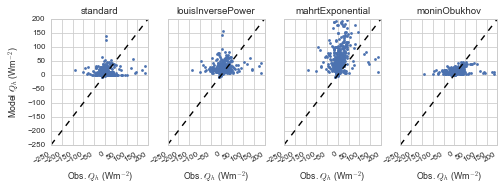

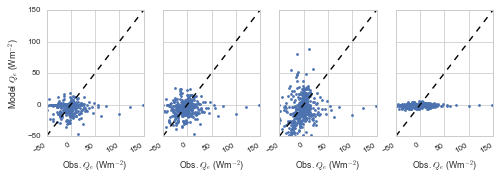

In [17]:
########
# Model Sensible vs Obs Sensible 
os.chdir(dirPrint)
fig,axes = plt.subplots(1,4,sharey=True,figsize=(8,2.5))
Qmax = 200
Qmin = -250

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(support.SensFlux[ind], sensible[stab],'.',label=stab)
    ax.plot([Qmin,Qmax],[Qmin,Qmax],'--k')
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlim(Qmin,Qmax)
    ax.set_xlabel('Obs. $Q_h$ (Wm$^{-2}$)')
    ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('Model $Q_h$ (Wm$^{-2}$)')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Sensible.pdf')

########
# Model Latent vs Obs Latent 
os.chdir(dirPrint)
fig,axes = plt.subplots(1,4,sharey=True,figsize=(8,2.5))
Qmax = 150
Qmin = -50

for n,stab in enumerate(ixStability):
    ax = axes[n]
    ax.plot(support.LatFlux[ind], latent[stab],'.',label=stab)
    ax.plot([Qmin,Qmax],[Qmin,Qmax],'--k')
    ax.set_ylim(Qmin,Qmax)
    ax.set_xlim(Qmin,Qmax)
    ax.set_xlabel('Obs. $Q_e$ (Wm$^{-2}$)')
#     ax.set_title(stab)

ax = axes[0]
ax.set_ylabel('Model $Q_e$ (Wm$^{-2}$)')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Latent.pdf')


# Compare to full SUMMA

In [ ]:
#############
#############
# Need to push Ryan's SUMMA output from unix box to google drive.
# See previous plots, the results should not have changed
#############
#############
os.chdir(dirData+'/SUMMA')
# Differences between SUMMA runs not important
summarun1 = xray.open_dataset('Snoqualmie_R_8203_2012-2013Temp_Pertub.nc')
summarun2 = xray.open_dataset('Snoqualmie_R_8204_2012-2013Temp_Pertub.nc')

s1 = xray.Dataset()
s1 = xray.Dataset({'sensible': (['time'], summarun1.scalarSenHeatTotal.values.flatten()),\
      'latent': (['time'], summarun1.scalarLatHeatTotal.values.flatten())},\
     coords= {'time': summarun1.time})
s1 = s1.reindex_like(support)


s2 = xray.Dataset()
s2 = xray.Dataset({'sensible': (['time'], summarun2.scalarSenHeatTotal.values.flatten()),\
      'latent': (['time'], summarun2.scalarLatHeatTotal.values.flatten())},\
     coords= {'time': summarun2.time})
s2 = s2.reindex_like(support)


In [ ]:
########
# Model Sensible vs Obs Sensible 
os.chdir(dirPrint)
fig,axes = plt.subplots(2,2,sharey=True,sharex=True,figsize=(9,9))
Qmax = 200
Qmin = -250
d1 = summarun1.time[0]
d2 = summarun1.time[-1]

# Run 1 - sensible
ax = axes[0][0]
ax.plot(support.SensFlux, s1.sensible,'.')
ax.plot(support.SensFlux.where(support.SP==1), s1.sensible.where(support.SP==1),'.')
ax.plot([Qmin,Qmax],[Qmin,Qmax],'--k')
ax.set_ylim(Qmin,Qmax)
ax.set_xlim(Qmin,Qmax)
ax.set_xlabel('Obs. $Q_h$ (Wm$^{-2}$)')
ax.set_title('Obs. radiation')
ax.set_ylabel('Model $Q_h$ (Wm$^{-2}$)')

# Run 1 - latent
ax = axes[1][0]
ax.plot(support.LatFlux, s1.latent,'.')
ax.plot(support.SensFlux.where(support.SP==1), s1.latent.where(support.SP==1),'.')
ax.plot([Qmin,Qmax],[Qmin,Qmax],'--k')
ax.set_ylim(Qmin,Qmax)
ax.set_xlim(Qmin,Qmax)
ax.set_xlabel('Obs. $Q_h$ (Wm$^{-2}$)')
ax.set_title('Obs. radiation')
ax.set_ylabel('Model $Q_h$ (Wm$^{-2}$)')

# Run 2 - sensible
ax = axes[0][1]
ax.plot(support.LatFlux, s2.latent,'.')
ax.plot(support.SensFlux.where(support.SP==1), s2.sensible.where(support.SP==1),'.')
ax.plot([Qmin,Qmax],[Qmin,Qmax],'--k')
ax.set_ylim(Qmin,Qmax)
ax.set_xlim(Qmin,Qmax)
ax.set_xlabel('Obs. $Q_h$ (Wm$^{-2}$)')
ax.set_title('Sim. radiation')
ax.set_ylabel('Model $Q_h$ (Wm$^{-2}$)')

# Run 2 - latent
ax = axes[1][1]
ax.plot(support.LatFlux, s2.latent,'.')
ax.plot(support.SensFlux.where(support.SP==1), s2.latent.where(support.SP==1),'.')
ax.plot([Qmin,Qmax],[Qmin,Qmax],'--k')
ax.set_ylim(Qmin,Qmax)
ax.set_xlim(Qmin,Qmax)
ax.set_xlabel('Obs. $Q_h$ (Wm$^{-2}$)')
ax.set_title('Sim. radiation')
ax.set_ylabel('Model $Q_h$ (Wm$^{-2}$)')


fig.autofmt_xdate()
fig.savefig('TF.SUMMATurb_Ryan.SNQ.pdf')

In [ ]:
fig,ax = plt.subplots(1,1)
ax.plot(summarun1.time,summarun1.scalarSenHeatTotal,label='SUMMA')
ax.plot(support.time,support.SensFlux,label='obs')
ax.set_ylabel('$Q_h (Wm^{-2})$')
ax.set_xlim(datetime(2012,10,1),datetime(2013,6,1))
ax.legend()

fig.autofmt_xdate()